In [1]:
using CSV, DataFrames, Plots, GLM, CategoricalArrays, StatsBase
include("../src/WassersteinVariance.jl")

WV_screening (generic function with 1 method)

In [2]:
df = CSV.read("../data/edu-atttain.csv", DataFrame)
inds = findall(col -> eltype(col) <: String, eachcol(df)) # col indices that are strings
for i in inds; df[!, i] .= categorical(df[!,i]) end # map string cols to categorical variables

In [3]:
covariates = select(df, ["gender","ethnicity","score","fcollege","mcollege","home","urban","unemp","wage","tuition","income","region"])
resp = Int.(df[!, :education] .>= 16)
tmp = hcat(covariates, resp)
ts = term.(names(select(tmp, Not(:x1))))
f = term(:x1) ~ sum(ts)
ols = lm(f, tmp)
X = ols.mm.m[:,2:end]
n = size(X,1)

E = 2
dists_to_school = Array(df[!, :distance])
qs = cut(dists_to_school, E) # divides values into 4 quantiles
env_inds = levelcode.(qs)

#env1 = findall(x->!iszero(x), df[!, :distance] .> median(df[!, :distance]))
#env2 = findall(x->!iszero(x), df[!, :distance] .<= median(df[!, :distance]))
Envs = [findall(x->x==i, env_inds) for i in 1:E]
nₑs = length.(Envs)
env_sort_inds = vcat(Envs...)

#n1 = length(env1)
#n2 = length(env2)
#env_sorted_inds = vcat(env1, env2);

In [4]:
xticklabs = GLM.coeftable(ols).rownms[2:end];

In [5]:
dt = fit(ZScoreTransform, X, dims=1)
X_norm = StatsBase.transform(dt, X);

In [6]:
#nₑs = [n1, n2]
wv = DirectWassersteinVariance(X_norm[env_sort_inds,:], resp[env_sort_inds], nₑs, nₑs / n)
res = WV_screening(wv, α=0.1, solver=LBFGS(m=100), B=100)

______________________________________
-          Initialization...          
______________________________________
-         Treating variable 1        
______________________________________
-         Treating variable 2        
______________________________________
-         Treating variable 3        
______________________________________
-         Treating variable 4        
______________________________________
-         Treating variable 5        
______________________________________
-         Treating variable 6        
______________________________________
-         Treating variable 7        
______________________________________
-         Treating variable 8        
______________________________________
-         Treating variable 9        
______________________________________
-         Treating variable 10        
______________________________________
-         Treating variable 11        
______________________________________
-         Treating variable 12    

([1.824602962007919e-5, 1.3594977002515161e-5, 1.3016694393216578e-5, 5.268937965171387e-5, 9.593937744939474e-6, 1.3554796137952262e-5, 2.0179921335775404e-5, 1.872569164036129e-5, 1.555278334320114e-5, 1.2702129284308297e-5, 1.3401306396241006e-5, 1.285048894961808e-5, 1.0955317196495608e-5], Bool[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 1.3370131835552751e-5, [0.6323741678386405, 0.8735251766297468, 0.8954400236700013, 0.00043153771162207644, 0.9776488111938009, 0.8751218497366575, 0.5177790603602558, 0.6038989977671054, 0.7835931053216212, 0.9063822522962127, 0.8811204172454382, 0.9013085655754302, 0.9543857529720304], 3.0615808073278366e-5)

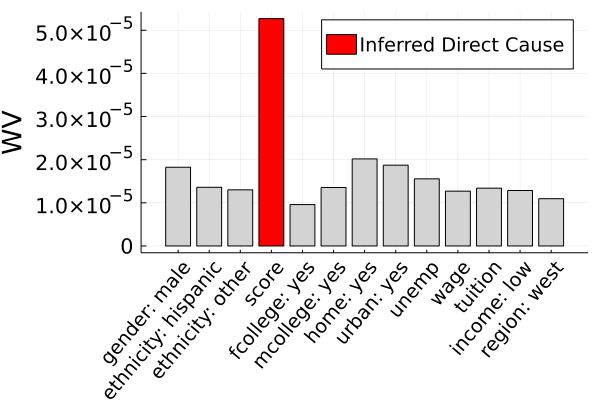

In [7]:
p = size(df,2)
groups = ones(p-1)
groups[4] = 2
b1 = bar(0.5:p-1,res[1], group=groups, fc=[:lightgrey :red], label=["" "Inferred Direct Cause"], ylabel="WV",
xrotation=50, xtickfontsize=13, ytickfontsize=14, yguidefontsize=18, legendfontsize=13, dpi=100)
plot!(xticks=(0.5:size(df,2)-1, xticklabs))

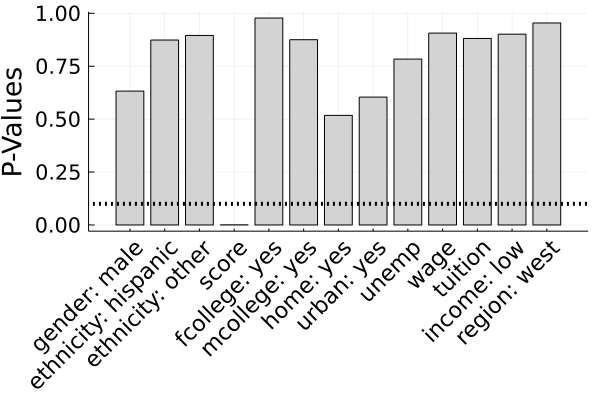

In [8]:
#bar(res[end-1], legend=false, title="pvals")
b2 = bar(0.5:p-1,res[end-1], group=groups, fc=[:lightgrey :red], leg=false, ylabel="P-Values", xrotation=45,
xtickfontsize=15, ytickfontsize=14, yguidefontsize=18, xguidefontsize=18, dpi=100)
hline!([0.1], linestyle = :dot, color=:black, linewidth=4)
plot!(xticks=(0.5:p-1, xticklabs))